---
title: "logistic regression"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## question

We are given a list of heights for men and women. Given one more data point (180 cm), could we assign a probability that it belongs to either class?

## discriminative model

The idea behind the logistic regression is to find a boundary between our two classes (here men and women). The logistic regression models the probability of a class given a data point, i.e. $P(y|x)$.
We can use the logistic function to model this probability:

$$P(y=1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x)}}$$

where $y$ is the class (0=women, 1=men), $x$ is the data point (height), and $\beta_0$ and $\beta_1$ are the parameters of the model.

Our goal is to find the best s-shaped curve that describes the data. This is done by finding the parameters $\beta_0$ and $\beta_1$ that maximize the likelihood of the data.


In [1]:
#| code-summary: "import libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm

In [2]:
#| code-summary: "generate data"
df_boys = pd.read_csv('../archive/data/height/boys_height_stats.csv', index_col=0)
df_girls = pd.read_csv('../archive/data/height/girls_height_stats.csv', index_col=0)
age = 20.0
mu_boys = df_boys.loc[age, 'mu']
mu_girls = df_girls.loc[age, 'mu']
sigma_boys = df_boys.loc[age, 'sigma']
sigma_girls = df_girls.loc[age, 'sigma']

N_boys = 150
N_girls = 200
np.random.seed(314)  # set scipy seed for reproducibility
sample_boys = norm.rvs(size=N_boys, loc=mu_boys, scale=sigma_boys)
sample_girls = norm.rvs(size=N_girls, loc=mu_girls, scale=sigma_girls)
# pandas dataframe with the two samples in it
df = pd.DataFrame({
    'height (cm)': np.concatenate([sample_boys, sample_girls]),
    'sex': ['M'] * N_boys + ['F'] * N_girls
})
df = df.sample(frac=1, random_state=314).reset_index(drop=True)
df

,height (cm),sex
0,178.558416,M
1,173.334306,M
2,183.084154,M
3,178.236047,F
4,175.868642,M
...,...,...
345,177.387837,M
346,157.122325,F
347,166.891746,F
348,181.090312,M


In [3]:
#| code-summary: "compute logistic regression using sklearn" 
#| code-fold: false
X = df['height (cm)'].values.reshape(-1, 1)
y = df['sex'].map({'M': 1, 'F': 0}).values
log_reg_2 = LogisticRegression(penalty=None, solver = 'newton-cg', max_iter= 150).fit(X,y)
beta1 = log_reg_2.coef_[0][0]
beta0 = log_reg_2.intercept_[0]
def logistic_function(x, beta0, beta1):
    return 1 / (1 + np.exp(-(beta0 + beta1 * x)))

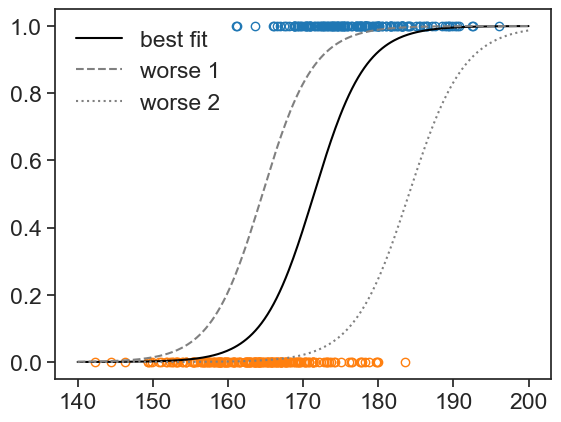

In [4]:
#| code-summary: "plot " 
fig, ax = plt.subplots()
ax.plot(sample_girls, np.zeros_like(sample_girls),
        linestyle='None', marker='o',
        markerfacecolor='none', markeredgecolor='tab:orange')
ax.plot(sample_boys, np.ones_like(sample_boys),
        linestyle='None', marker='o',
        markerfacecolor='none', markeredgecolor='tab:blue')

x_array = np.linspace(140, 200, 300).reshape(-1, 1)
y_proba = log_reg_2.predict_proba(x_array)[:, 1]
# ax.plot(x_array, y_proba, color='black')
ax.plot(x_array, logistic_function(x_array, beta0, beta1), color='black', label="best fit")
ax.plot(x_array, logistic_function(x_array, beta0+2, beta1), color='gray', linestyle='--', label="worse 1")
ax.plot(x_array, logistic_function(x_array, beta0, beta1-0.02), color='gray', linestyle=':', label="worse 2")
ax.legend(frameon=False)


## likelihood

How do we know the parameters of the **best** s-shaped curve? Let's pretend we have only three data points:

- Man, 180 cm. Data point $(180,1)$.
- Man, 170 cm. Data point $(170,1)$.
- Woman, 165 cm. Data point $(165,0)$.

In [5]:
#| code-summary: "recalculate logistic regression with 3 points" 
x3 = np.array([180.0, 170.0, 165.0])
y3 = np.array([1, 1, 0])
log_reg_3 = LogisticRegression(penalty=None, solver = 'newton-cg', max_iter= 150).fit(x3.reshape(-1, 1),y3)
beta1 = log_reg_3.coef_[0][0]
beta0 = log_reg_3.intercept_[0]

[Text(0.5, 0, 'height (cm)'), Text(0.5, 1.0, 'worse 2')]

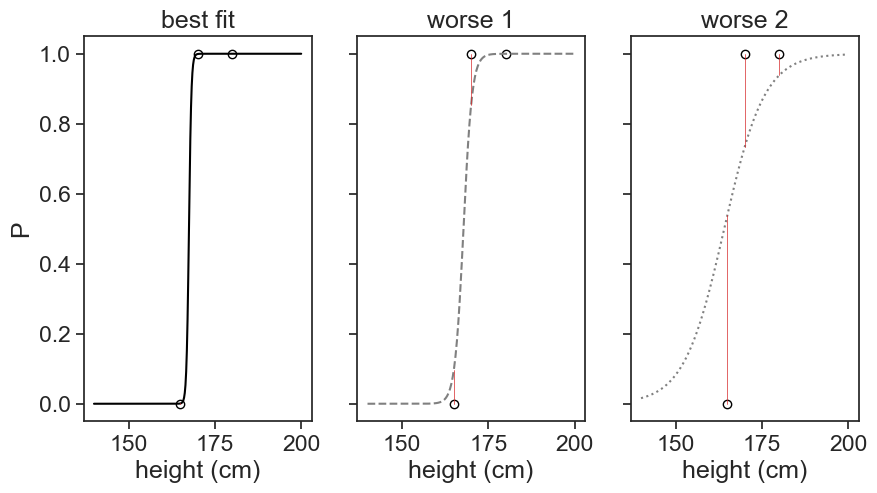

In [6]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)
x_array = np.linspace(140, 200, 300)

ya = logistic_function(x_array, beta0, beta1)
yb = logistic_function(x_array, beta0+344, beta1*0.28)
yc = logistic_function(x_array, beta0+450, beta1*0.06)
yhat3a = logistic_function(x3, beta0, beta1)
yhat3b = logistic_function(x3, beta0+344, beta1*0.28)
yhat3c = logistic_function(x3, beta0+450, beta1*0.06)

for axi in ax:
    axi.plot(x3, y3,
            linestyle='None', marker='o',
            markerfacecolor='none', markeredgecolor='black')

ax[0].plot(x_array, ya, color='black')
ax[1].plot(x_array, yb, color='gray', linestyle='--')
ax[2].plot(x_array, yc, color='gray', linestyle=':')

for i in range(len(x3)):
    ax[0].plot([x3[i], x3[i]], [y3[i], yhat3a[i]], color='tab:red', linestyle='-', lw=0.5)
    ax[1].plot([x3[i], x3[i]], [y3[i], yhat3b[i]], color='tab:red', linestyle='-', lw=0.5)
    ax[2].plot([x3[i], x3[i]], [y3[i], yhat3c[i]], color='tab:red', linestyle='-', lw=0.5)

ax[0].set(xlabel="height (cm)",
          ylabel="P",
          title="best fit")
ax[1].set(xlabel="height (cm)",
          title="worse 1")
ax[2].set(xlabel="height (cm)",
            title="worse 2")

As usual, our task in performing the regression is to find the parameters $\beta_0$ and $\beta_1$ that minimize the distance between the model and the data (the residual). See the figure above, we plotted the same three data points, and in each panel we see a different s-shaped curve (black) and the distance between the model and the data (red lines).

\[Note: this time, because we have only three data points, the best fit gave us an extremely sharp logistic function, that neatly discriminates between the data points. In the first example, the function was much more "shallow", because of the overlap between the Men and Women datasets.\]

In the logistic regression, instead of **minimizing the residual**, we **maximize the likelihood** of the data given the model parameters. The likelihood is the complement of the residual, see the thick red bars in the figure below.

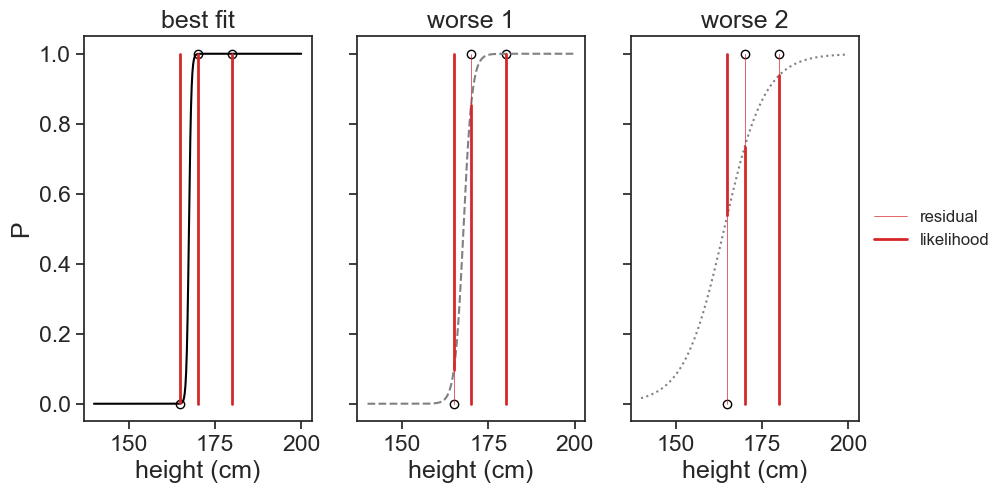

In [7]:
#| code-summary: "plot"
fig, ax = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)

for axi in ax:
    axi.plot(x3, y3,
            linestyle='None', marker='o',
            markerfacecolor='none', markeredgecolor='black')

ax[0].plot(x_array, ya, color='black')
ax[1].plot(x_array, yb, color='gray', linestyle='--')
ax[2].plot(x_array, yc, color='gray', linestyle=':')

for i in range(len(x3)):
    ax[0].plot([x3[i], x3[i]], [y3[i], yhat3a[i]], color='tab:red', linestyle='-', lw=0.5)
    ax[0].plot([x3[i], x3[i]], [not bool(y3[i]), yhat3a[i]], color='tab:red', linestyle='-', lw=2)
    ax[1].plot([x3[i], x3[i]], [y3[i], yhat3b[i]], color='tab:red', linestyle='-', lw=0.5)
    ax[1].plot([x3[i], x3[i]], [not bool(y3[i]), yhat3b[i]], color='tab:red', linestyle='-', lw=2)
    ax[2].plot([x3[i], x3[i]], [y3[i], yhat3c[i]], color='tab:red', linestyle='-', lw=0.5)
    ax[2].plot([x3[i], x3[i]], [not bool(y3[i]), yhat3c[i]], color='tab:red', linestyle='-', lw=2)

ax[2].plot([], [], color='tab:red', linestyle='-', lw=0.5, label="residual")
ax[2].plot([], [], color='tab:red', linestyle='-', lw=2, label="likelihood")

ax[0].set(xlabel="height (cm)",
          ylabel="P",
          title="best fit")
ax[1].set(xlabel="height (cm)",
          title="worse 1")
ax[2].set(xlabel="height (cm)",
            title="worse 2")
ax[2].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

What is the probability that we would measure the observed data, given the model parameters?
For a single data point (height, class), the length of the red bars can be described by the formula below:

$$
L(y_i|P_i) = P_i^{y_i} (1-P_i)^{1-y_i}.
$$

For instance, if the data point corresponds to a man ($y_i=1$), we have $L=P_i$. The likelihood (thick red bars) for men is just the value of the logistic function for that value of $x$. For women ($y_i=0$), we have $L=1-P_i$. The likelihood for women is just the complement (one minus) of the logistic function.

Assuming that each data point is independent, the likelihood of the entire dataset is the product of the likelihoods of each data point:

$$
L(\beta_0, \beta_1) = \prod_{i=1}^{N} P_i^{y_i} (1-P_i)^{1-y_i}.
$$

In the example below, the likelihood of the entire dataset for each panel is as follows:

In [8]:
#| code-summary: "compute likelihoods"
La = 1.0
Lb = 1.0
Lc = 1.0
for i in range(len(x3)):
    La = La * yhat3a[i]**y3[i] * (1-yhat3a[i])**(1-y3[i])
    Lb = Lb * yhat3b[i]**y3[i] * (1-yhat3b[i])**(1-y3[i])
    Lc = Lc * yhat3c[i]**y3[i] * (1-yhat3c[i])**(1-y3[i])
print("Likelihood for best fit: ", La)
print("Likelihood for worse 1: ", Lb)
print("Likelihood for worse 2: ", Lc)

Likelihood for best fit:  0.9984099891897481
Likelihood for worse 1:  0.7711068593851899
Likelihood for worse 2:  0.3173593316343797


As we increase the number of data points, the likelihood becomes very small (because we are multiplying many numbers between 0 and 1). To avoid numerical issues, we usually work with the log-likelihood.

## log-likelihood

The log-likelihood is the logarithm of the likelihood:

$$
\ell(\beta_0, \beta_1) = \log L(\beta_0, \beta_1) = \sum_{i=1}^{N} P_i^{y_i} (1-P_i)^{1-y_i}
$$

Using the properties of logarithms, we can rewrite the log-likelihood as follows:

$$
\ell(\beta_0, \beta_1) = \sum_{i=1}^{N} \left( y_i \log P_i + (1-y_i) \log (1-P_i) \right).
$$

## binary cross-entropy, or log loss

We can use gradient descent to find the parameters that maximize the log-likelihood. Most implementations of gradient descent are designed to minimize a cost function. Therefore, instead of maximizing the log-likelihood, we can minimize the negative log-likelihood:

$$
J(\beta_0, \beta_1) = -\ell(\beta_0, \beta_1) = -\sum_{i=1}^{N} \left( y_i \log P_i + (1-y_i) \log (1-P_i) \right).
$$
This cost function is also known as binary cross-entropy or log loss.

It turns out that taking the log of the likelihood is very convenient. What was before only a trick to avoid numerical issues, now has a nice interpretation. The cross-entropy can be thought of as a measure of "surprise". The more the model is surprised by the data, the higher the cross-entropy, and the poorer the fit. The less surprised the model is by the data, the lower the cross-entropy, and the better the fit.

## wrapping up

From the provided data:

* What is the probability that a person whose height is 180 cm is a man?
* If we had to choose one height to discriminate between men and women, what would it be?

Let's run the code for the logistic regression again:

[(140.0, 200.0), Text(0.5, 0, 'height (cm)'), Text(0, 0.5, 'P')]

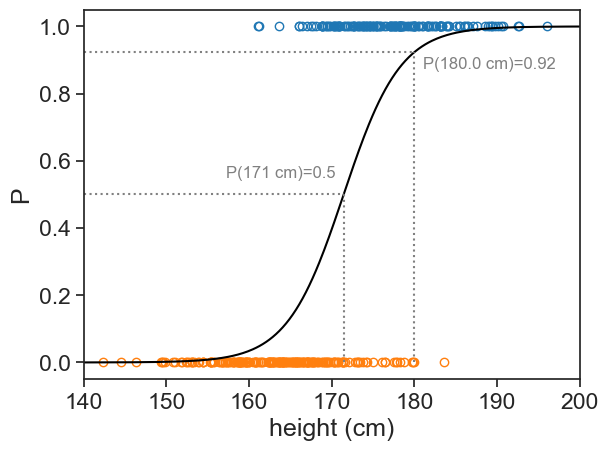

In [36]:
#| code-summary: "compute logistic regression and plot" 
X = df['height (cm)'].values.reshape(-1, 1)
y = df['sex'].map({'M': 1, 'F': 0}).values
log_reg_2 = LogisticRegression(penalty=None, solver = 'newton-cg', max_iter= 150).fit(X,y)
beta1 = log_reg_2.coef_[0][0]
beta0 = log_reg_2.intercept_[0]

#| code-summary: "plot " 
fig, ax = plt.subplots()
ax.plot(sample_girls, np.zeros_like(sample_girls),
        linestyle='None', marker='o',
        markerfacecolor='none', markeredgecolor='tab:orange')
ax.plot(sample_boys, np.ones_like(sample_boys),
        linestyle='None', marker='o',
        markerfacecolor='none', markeredgecolor='tab:blue')

x_array = np.linspace(140, 200, 300).reshape(-1, 1)
y_proba = log_reg_2.predict_proba(x_array)[:, 1]
# ax.plot(x_array, y_proba, color='black')
ax.plot(x_array, logistic_function(x_array, beta0, beta1), color='black', label="best fit")

h = 180.0
p180 = log_reg_2.predict_proba(np.array([[h]]))[0, 1]
ax.plot([h, h], [0, p180], color='gray', linestyle=':')
ax.plot([np.min(x_array), h], [p180, p180], color='gray', linestyle=':')
ax.text(h+1, p180-0.05, f"P({h} cm)={p180:.2f}", color='gray', fontsize=12)

p_50percent = -beta0 / beta1
ax.plot([p_50percent, p_50percent], [0, 0.5], color='gray', linestyle=':')
ax.plot([np.min(x_array), p_50percent], [0.5, 0.5], color='gray', linestyle=':')
ax.text(p_50percent-1, 0.5+0.05, f"P({p_50percent:.0f} cm)=0.5", color='gray', fontsize=12, ha='right')


ax.set(xlim=(140, 200),
       xlabel="height (cm)",
       ylabel="P",)

Answers:

* The probability that a person 180 cm tall is a man is 92%.
* The height that best discriminates between men (above) and women (below) is 171 cm.

This last result follows directly from:

\begin{align*}
P(x) = \frac{1}{1+\exp[-(\beta_0+\beta_1 x)]} &= \frac{1}{2} \\
& \text{therefore} \\
1+\exp[-(\beta_0+\beta_1 x)] &= 2 \\
\exp[-(\beta_0+\beta_1 x)] &= 1 \\
-(\beta_0+\beta_1 x) &= 0 \\
x &= -\frac{\beta_0}{\beta_1}
\end{align*}

Compare this result with the one we obtained with the [parametric generative model](/bayes/parametric-generative-classification.html) discussed in the Bayes' theorem section.